### Import the necessary libraries

In [122]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.inspection import permutation_importance

### Read data

In [123]:
df = gpd.read_file('../data/processed/high_res.shp')

### Predict only using population density and HDI

In [124]:
#fit random forest model
X = df[['Pop_den', "HDI"]]  # Features
feature_names =  X.columns.tolist()
y = df['Cases']

# Stratify based on 'Province'
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(
    X, y, df.index, test_size=0.2, random_state=38, stratify=df[["Province"]])

# Now you have train_index and test_index containing the original indices
# of the rows that went into training and testing sets respectively.

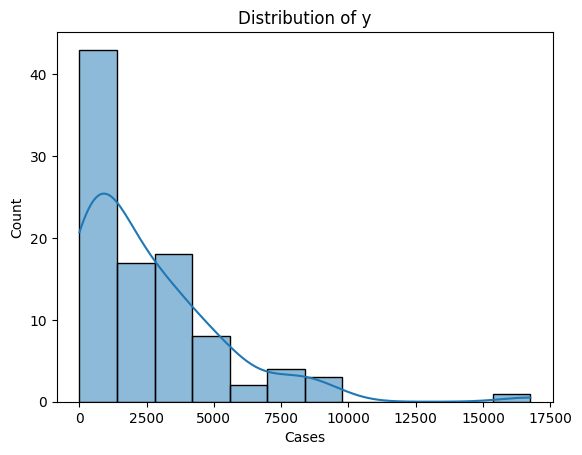

Skewness: 2.0902571464860418


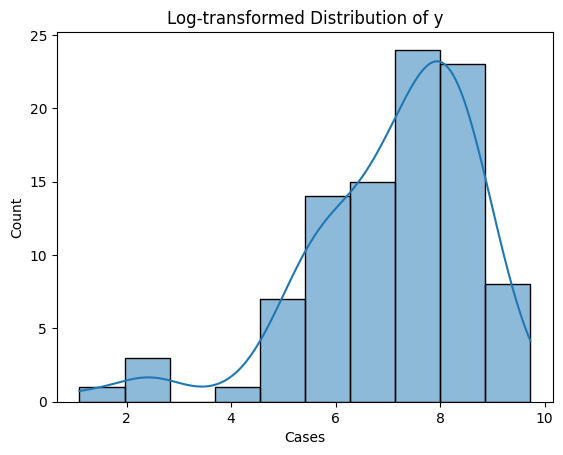

In [125]:
#plot the distribution of y to determine whether i need to log transform it
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of y
sns.histplot(y, kde=True)
plt.title("Distribution of y")
plt.show()

# Check if the distribution is highly skewed (optional)
skewness = y.skew()
print(f"Skewness: {skewness}")

# If skewed, apply log transformation and plot again
if skewness > 1:  # You can adjust this threshold based on your data
    y_log = np.log1p(y)  # log1p is log(1 + y), handles zeros gracefully
    sns.histplot(y_log, kde=True)
    plt.title("Log-transformed Distribution of y")
    plt.show()


In [126]:
#since log transforming doesnt rly help, can winzorise instead:
# Manual winsorization with pandas
lower = y.quantile(0.05)
upper = y.quantile(0.95)
y_winsorized = y.clip(lower=lower, upper=upper)


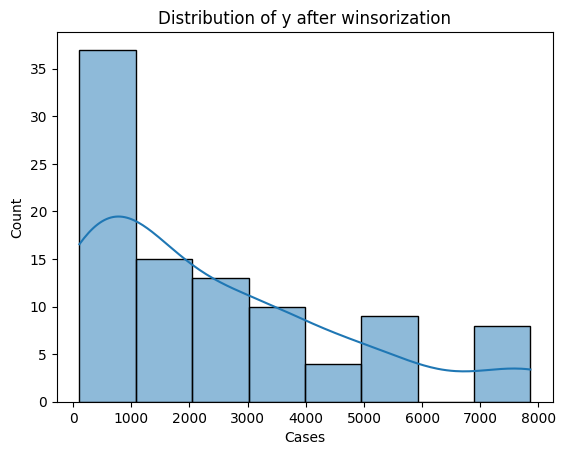

Skewness: 1.0192731300317661


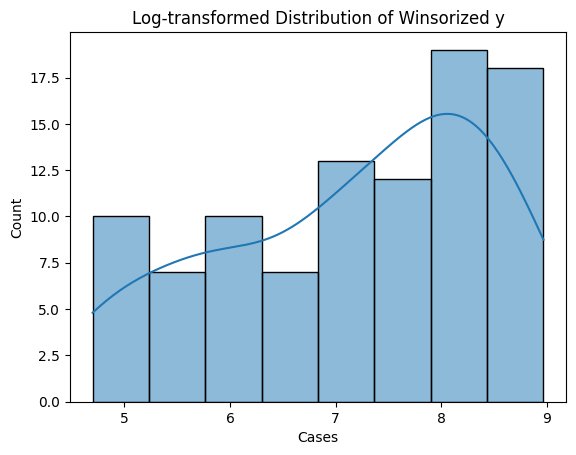

In [148]:
#check plot for y_winsorized
# Plot the distribution of y
sns.histplot(y_winsorized, kde=True)
plt.title("Distribution of y after winsorization")
plt.show()

# Check if the distribution is highly skewed (optional)
skewness = y_winsorized.skew()
print(f"Skewness: {skewness}")

# If skewed, apply log transformation and plot again
if skewness > 1:  # You can adjust this threshold based on your data
    y_log = np.log1p(y_winsorized)  # log1p is log(1 + y), handles zeros gracefully
    sns.histplot(y_log, kde=True)
    plt.title("Log-transformed Distribution of Winsorized y")
    plt.show()

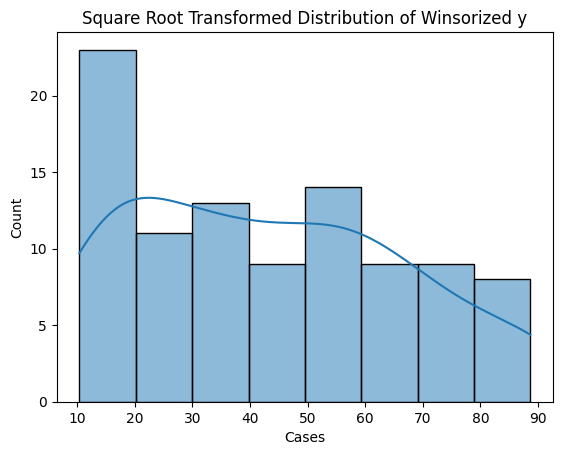

Skewness of sqrt-transformed y: 0.3306538958740691


In [149]:
#how abt square rooting:
y_sqrt = np.sqrt(y_winsorized)  # Square root transformation
sns.histplot(y_sqrt, kde=True)
plt.title("Square Root Transformed Distribution of Winsorized y")
plt.show()
print(f"Skewness of sqrt-transformed y: {y_sqrt.skew()}")


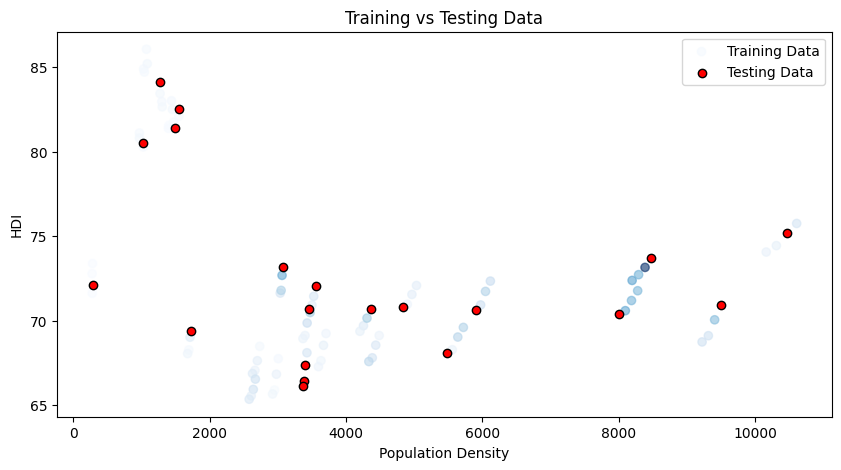

In [129]:
#To-do: plot training and testing data (One showing training points and another that shows testing points) with the prediction values
# Plot training and testing data
plt.figure(figsize=(10, 5))

# Scatter plot for Training Data
plt.scatter(X_train['Pop_den'], X_train['HDI'], c=y_train, cmap='Blues', label='Training Data', alpha=0.6)

# Scatter plot for Testing Data
plt.scatter(X_test['Pop_den'], X_test['HDI'], c='red', label='Testing Data', edgecolors='k')

plt.xlabel('Population Density')
plt.ylabel('HDI')
plt.legend()
plt.title('Training vs Testing Data')
plt.show()

In [130]:
#fit random forest into train-test split using y_winsorized, y_log, y_sqrt

# Stratify based on 'Province'
X_train, X_test, y_train_w, y_test_w, train_index, test_index = train_test_split(
    X, y_winsorized, df.index, test_size=0.2, random_state=38, stratify=df[["Province"]])

# Stratify based on 'Province'
X_train, X_test, y_train_l, y_test_l, train_index, test_index = train_test_split(
    X, y_log, df.index, test_size=0.2, random_state=38, stratify=df[["Province"]])

# Stratify based on 'Province'
X_train, X_test, y_train_s, y_test_s, train_index, test_index = train_test_split(
    X, y_sqrt, df.index, test_size=0.2, random_state=38, stratify=df[["Province"]])

In [131]:
# Create new dataset with NaN for testing 'Cases'
df_modified = df.copy()
df_modified.loc[test_index, 'Cases'] = np.nan  # Replace testing 'Cases' with NaN

# Save the dataset
df_modified.to_csv('../data/processed/df_aggVAE_rf_training_comparison.csv', index=False)

df_pointer = df.copy()
df_pointer["split"] = "train"
df_pointer.loc[test_index, 'split'] = 'test'

df_pointer.to_csv('../data/processed/df_aggVAE_rf_split.csv', index=False)

In [136]:
# Define your RandomForest model
rf = RandomForestRegressor(random_state=42)

# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000],
}

def run_grid_search(X, y, cv_folds):
    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=cv_folds,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error'
    )
    grid_search.fit(X, y)
    return pd.DataFrame(grid_search.cv_results_)

cv_10_results = run_grid_search(X_train, y_train, 10)
cv_10_results_w = run_grid_search(X_train, y_train_w, 10)
cv_10_results_l = run_grid_search(X_train, y_train_l, 10)
cv_10_results_s = run_grid_search(X_train, y_train_s, 10)


In [137]:
best_n = lambda results: results.loc[results['mean_test_score'].idxmax(), 'param_n_estimators']

print(f"Optimal n_estimators for 10-fold CV: {best_n(cv_10_results)}")
print(f"Optimal n_estimators for 10-fold CV with y_winsorized: {best_n(cv_10_results_w)}")
print(f"Optimal n_estimators for 10-fold CV with y_log: {best_n(cv_10_results_l)}")
print(f"Optimal n_estimators for 10-fold CV with y_sqrt: {best_n(cv_10_results_s)}")


Optimal n_estimators for 10-fold CV: 200
Optimal n_estimators for 10-fold CV with y_winsorized: 1000
Optimal n_estimators for 10-fold CV with y_log: 1000
Optimal n_estimators for 10-fold CV with y_sqrt: 1000


In [143]:
#calculate MAE, RMSE, rhat for all those and choose the one w lowest RMSE and highest Rhat
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

results = []

# Original y
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
results.append({
    'version': 'original',
    'MAE': mean_absolute_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'R2': r2_score(y_test, y_pred)
})

# Winsorized y
rf_w = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_w.fit(X_train, y_train_w)
y_pred_w = rf_w.predict(X_test)
results.append({
    'version': 'winsorized',
    'MAE': mean_absolute_error(y_test, y_pred_w),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_w)),
    'R2': r2_score(y_test, y_pred_w)
})

# Square root transformed y
rf_s = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_s.fit(X_train, y_train_s)
y_pred_s = rf_s.predict(X_test)
# Inverse transform sqrt: square the predictions
y_pred_s_inv = y_pred_s ** 2
results.append({
    'version': 'sqrt',
    'MAE': mean_absolute_error(y_test, y_pred_s_inv),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_s_inv)),
    'R2': r2_score(y_test, y_pred_s_inv)
})

# Log transformed y
rf_l = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_l.fit(X_train, y_train_l)
y_pred_l = rf_l.predict(X_test)
# Inverse transform log1p: expm1
y_pred_l_inv = np.expm1(y_pred_l)
results.append({
    'version': 'log',
    'MAE': mean_absolute_error(y_test, y_pred_l_inv),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_l_inv)),
    'R2': r2_score(y_test, y_pred_l_inv)
})

# Turn results into a DataFrame and find the best version
results_df = pd.DataFrame(results)
best_version = results_df.sort_values(by=['RMSE', 'R2'], ascending=[True, False]).iloc[0]

print("All Results:\n", results_df)
print("\nBest version:\n", best_version)

All Results:
       version          MAE         RMSE        R2
0    original  1523.917500  2210.564836 -0.539844
1  winsorized  1237.401600  1568.997947  0.224262
2        sqrt  1210.111899  1536.745083  0.255827
3         log  1155.170566  1520.566830  0.271413

Best version:
 version            log
MAE        1155.170566
RMSE        1520.56683
R2            0.271413
Name: 3, dtype: object


C:\Users\jessi\AppData\Local\Temp\ipykernel_10512\3634410907.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True, color="blue")


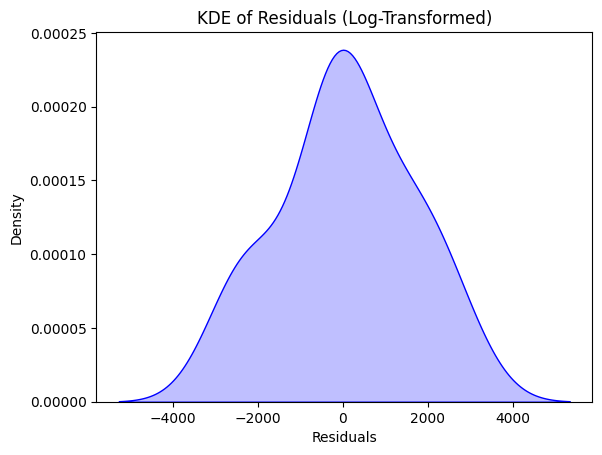

In [151]:
#plot the distribution of errors
# Calculate residuals (difference between observed and predicted values)
residuals = y_test - y_pred_l_inv

# Plot KDE of residuals
sns.kdeplot(residuals, shade=True, color="blue")
plt.title('KDE of Residuals (Log-Transformed)')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

In [144]:
# Add the predictions of y_sqrt winsorized to the test set (preserving indices)
X_test['Predicted_Cases'] = np.expm1(y_pred_l)

# Now merge predictions back to the original dataframe using the indices of X_test
df_with_predictions = pd.merge(df, X_test[['Predicted_Cases']],
                                left_index=True, right_index=True, how='left')

# Show the dataframe with predictions included
print(df_with_predictions)

         District           x         y  Year  Area_sq_km    HDI    Province  \
0         BANDUNG  107.610841 -7.099969  2020     1767.96  72.39  Jawa Barat   
1         BANDUNG  107.610841 -7.099969  2021     1767.96  72.73  Jawa Barat   
2         BANDUNG  107.610841 -7.099969  2022     1767.96  73.16  Jawa Barat   
3         BANDUNG  107.610841 -7.099969  2023     1767.96  73.74  Jawa Barat   
4   BANDUNG BARAT  107.414953 -6.897056  2020     1305.77  68.08  Jawa Barat   
..            ...         ...       ...   ...         ...    ...         ...   
91       SUMEDANG  107.980850 -6.825066  2023     1518.33  73.18  Jawa Barat   
92    TASIKMALAYA  108.141296 -7.496706  2020     2551.19  65.67  Jawa Barat   
93    TASIKMALAYA  108.141296 -7.496706  2021     2551.19  65.90  Jawa Barat   
94    TASIKMALAYA  108.141296 -7.496706  2022     2551.19  66.84  Jawa Barat   
95    TASIKMALAYA  108.141296 -7.496706  2023     2551.19  67.76  Jawa Barat   

    Cases  Population      Pop_den  \
0

In [145]:
#save the df with predictions
df_with_predictions.to_csv("../data/processed/df_combined_with_predictions_rf_popden_hdi.csv")

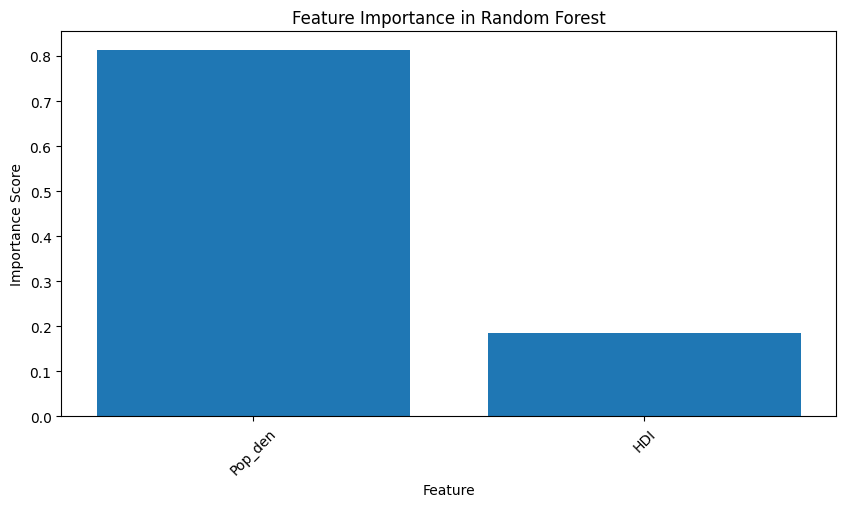

In [146]:
# Get feature importance
importances = rf_l.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.title("Feature Importance in Random Forest")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

In [147]:
# Save the model
with open("../model_weights/rf/random_forest_model_pop_den_hdi.pkl", "wb") as f:
    pickle.dump(rf, f)

# Load the model
#with open("random_forest_model.pkl", "rb") as f:
#    rf_loaded = pickle.load(f)